# Fidelity-based quality assessment

Author:  Daniel Proaño-Guevara

PRODEB

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import copy
import pickle

import preprocessing_lib as pplib
import feature_extraction_lib as ftelib

## Initial signals with their segmentation-delineation

## Phonocardiography (PCG)

ULSGE Dataset

In [2]:
root_dir = r'..\DatasetCHVNGE\pcg_ulsge.pkl'
pcg_df = pd.read_pickle(root_dir)
# Resample them to 50 Hz
pcg_df['Signal'] = pcg_df['Signal'].apply(
    lambda data: pplib.downsample(data, 3000, 50))

# Import Predictions
pred_path = r'..\ULSGE_pred_butter.pkl'
with open(pred_path, 'rb') as file:
    pcg_predictions = pickle.load(file)

### Show Raw Predictions

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\2803738050.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(pcg_df.iloc[63][2])[300:700], label = 'PCG raw')


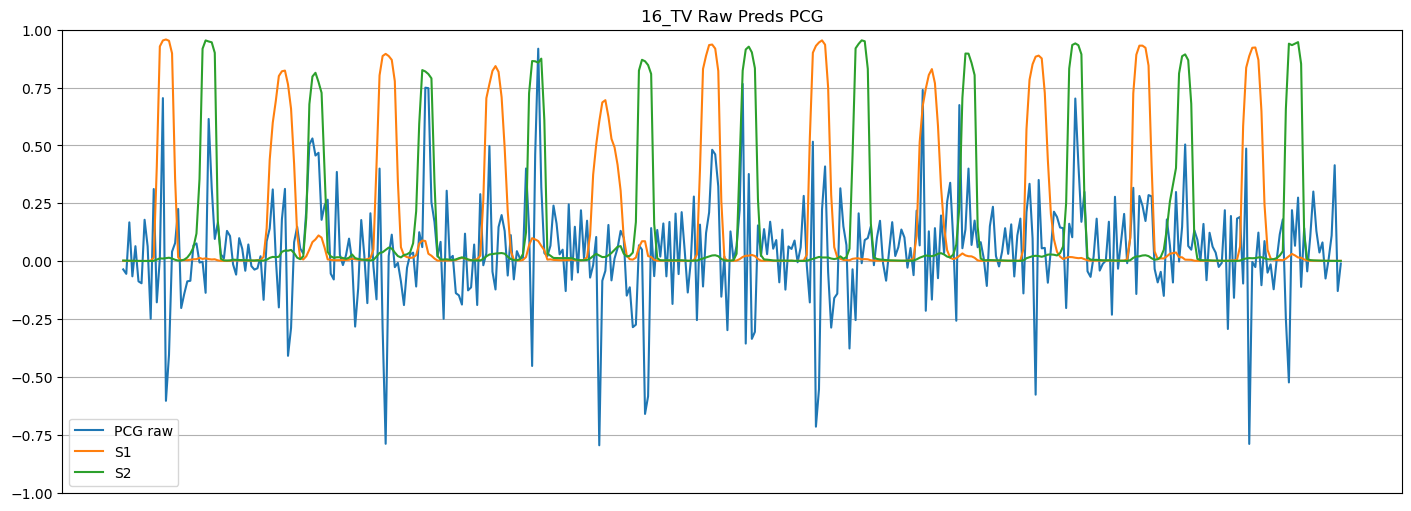

In [3]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Raw Preds PCG')
plt.plot(pplib.min_max_norm2(pcg_df.iloc[63][2])[300:700], label = 'PCG raw')
plt.plot(pcg_predictions[63][300:700, 0], label='S1')
plt.plot(pcg_predictions[63][300:700, 2], label='S2')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Smooth Predictions

In [4]:
AVERAGE_WINDOW = 3
pcg_processed_predictions = [
    np.column_stack([pplib.moving_average(data[:, i], AVERAGE_WINDOW) for i in range(4)])
    for data in pcg_predictions
]

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\1996985663.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(pcg_df.iloc[63][2])[300:700], label = 'PCG raw')


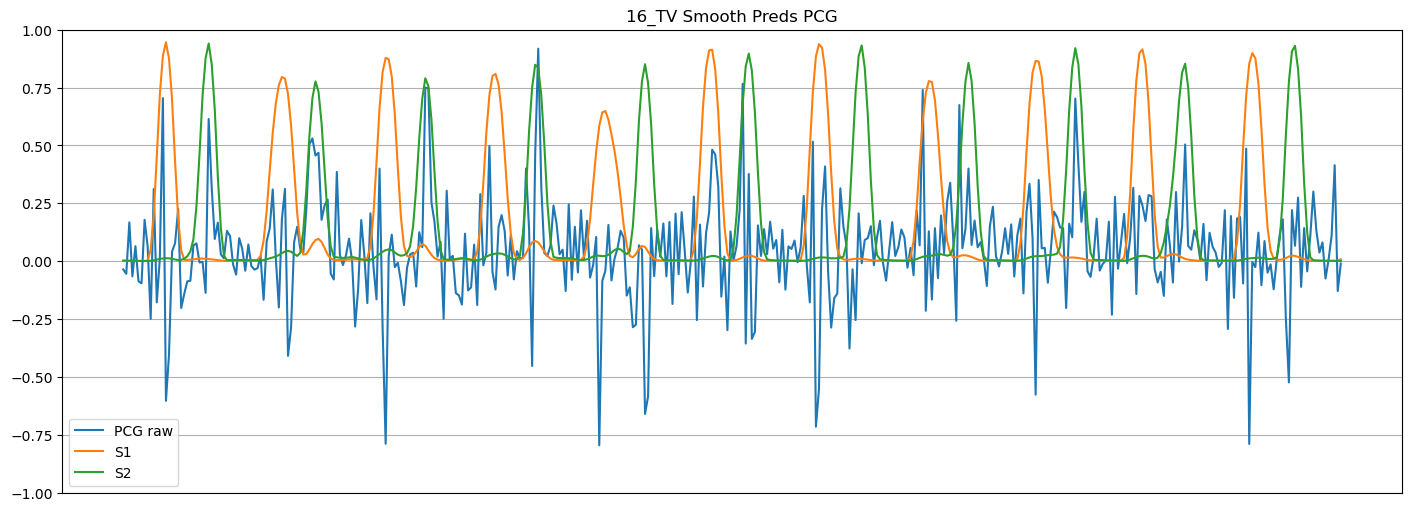

In [5]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Smooth Preds PCG')
plt.plot(pplib.min_max_norm2(pcg_df.iloc[63][2])[300:700], label = 'PCG raw')
plt.plot(pcg_processed_predictions[63][300:700, 0], label='S1')
plt.plot(pcg_processed_predictions[63][300:700, 2], label='S2')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Reverse One-hot encoding

In [6]:
pcg_pred_labels = [ftelib.reverse_one_hot_encoding(pred) for pred in pcg_processed_predictions]
pcg_prediction_labels = copy.deepcopy(pcg_pred_labels)
pcg_state_predictions = np.array([prediction for prediction in pcg_prediction_labels], dtype=object)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\589936484.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot((pplib.min_max_norm2(pcg_df.iloc[63][2])*2 +1.5)[300:700], label = 'PCG raw')


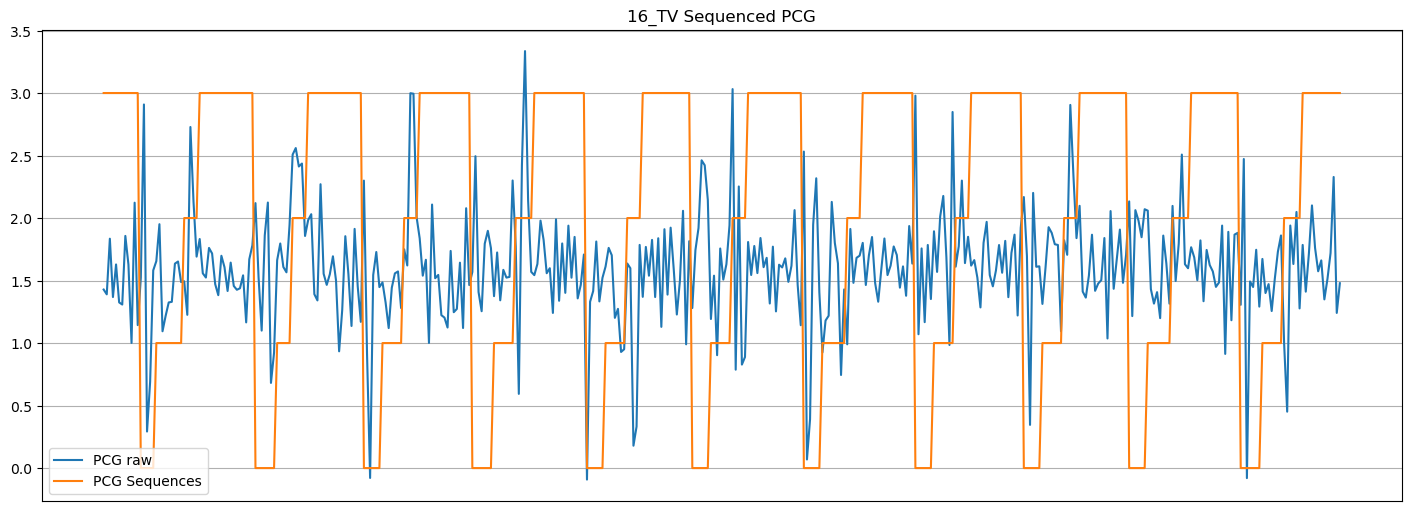

In [7]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Sequenced PCG')
plt.plot((pplib.min_max_norm2(pcg_df.iloc[63][2])*2 +1.5)[300:700], label = 'PCG raw')
plt.plot(pcg_state_predictions[63][300:700], label='PCG Sequences')
plt.xticks([])
#plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

## Electrocardiography (ECG)

In [8]:
root_dir = r'..\DatasetCHVNGE\ecg_ulsge.pkl'
ecg_df = pd.read_pickle(root_dir)
# Resample them to 50 Hz
ecg_df['Signal'] = ecg_df['Signal'].apply(
    lambda data: pplib.downsample(data, 500, 50))
# Import Predictions
predictions_pickle_path = r'..\ULSGE_ecg_pred.pkl'
with open(predictions_pickle_path, 'rb') as file:
    ecg_predictions = pickle.load(file)

### Show Raw predictions

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\1176862032.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(ecg_df.iloc[63][2])[300:700], label = 'ECG raw')


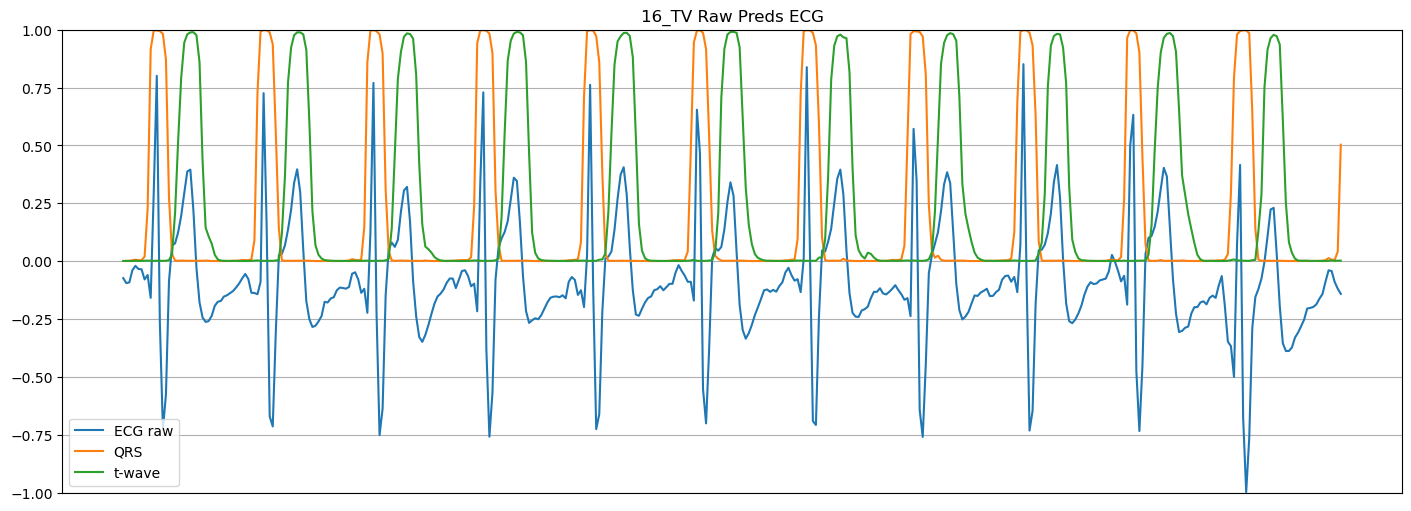

In [9]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Raw Preds ECG')
plt.plot(pplib.min_max_norm2(ecg_df.iloc[63][2])[300:700], label = 'ECG raw')
plt.plot(ecg_predictions[63][300:700, 2], label='QRS')
plt.plot(ecg_predictions[63][300:700, 3], label='t-wave')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Smooth Predictions

In [10]:
AVERAGE_WINDOW = 3
ecg_processed_predictions = [
    np.column_stack([pplib.moving_average(data[:, i], AVERAGE_WINDOW) for i in range(4)])
    for data in ecg_predictions
]

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\113911482.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(ecg_df.iloc[63][2])[300:700], label = 'ECG raw')


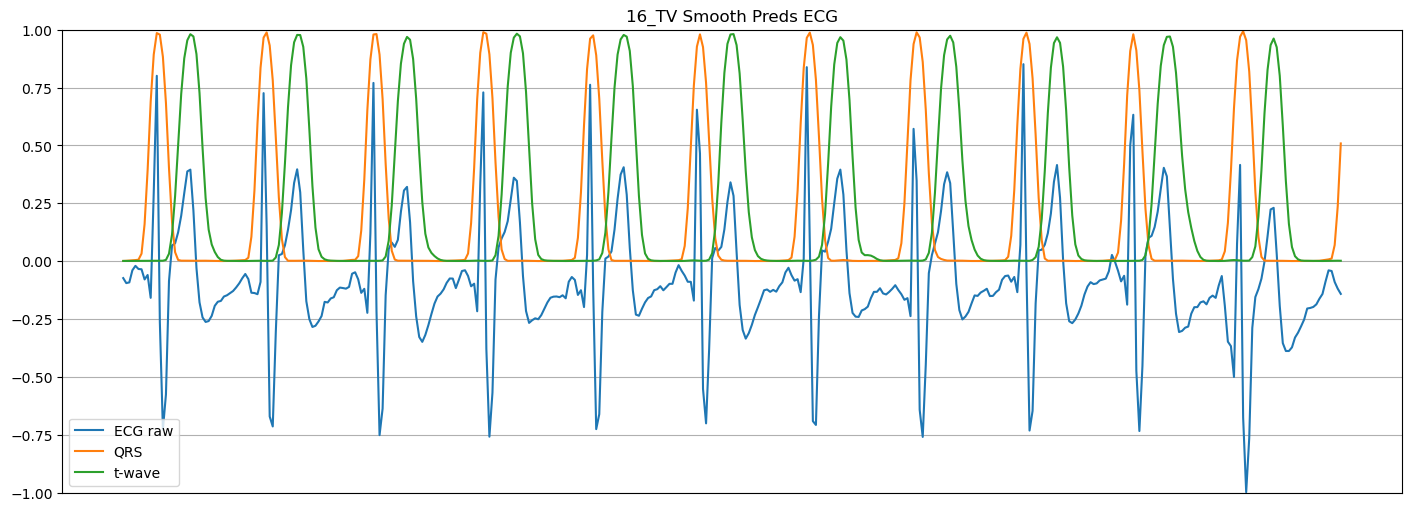

In [11]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Smooth Preds ECG')
plt.plot(pplib.min_max_norm2(ecg_df.iloc[63][2])[300:700], label = 'ECG raw')
plt.plot(ecg_processed_predictions[63][300:700, 2], label='QRS')
plt.plot(ecg_processed_predictions[63][300:700, 3], label='t-wave')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Reverse One-hot encoding

In [12]:
ecg_pred_labels = [ftelib.reverse_one_hot_encoding(pred, desired_order=[1, 3, 0, 2]) for pred in ecg_processed_predictions]
ecg_prediction_labels = copy.deepcopy(ecg_pred_labels)
ecg_state_predictions = np.array([prediction for prediction in ecg_prediction_labels], dtype=object)

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\2744463403.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot((pplib.min_max_norm2(ecg_df.iloc[63][2])*2 +1.5)[300:700], label = 'ECG raw')


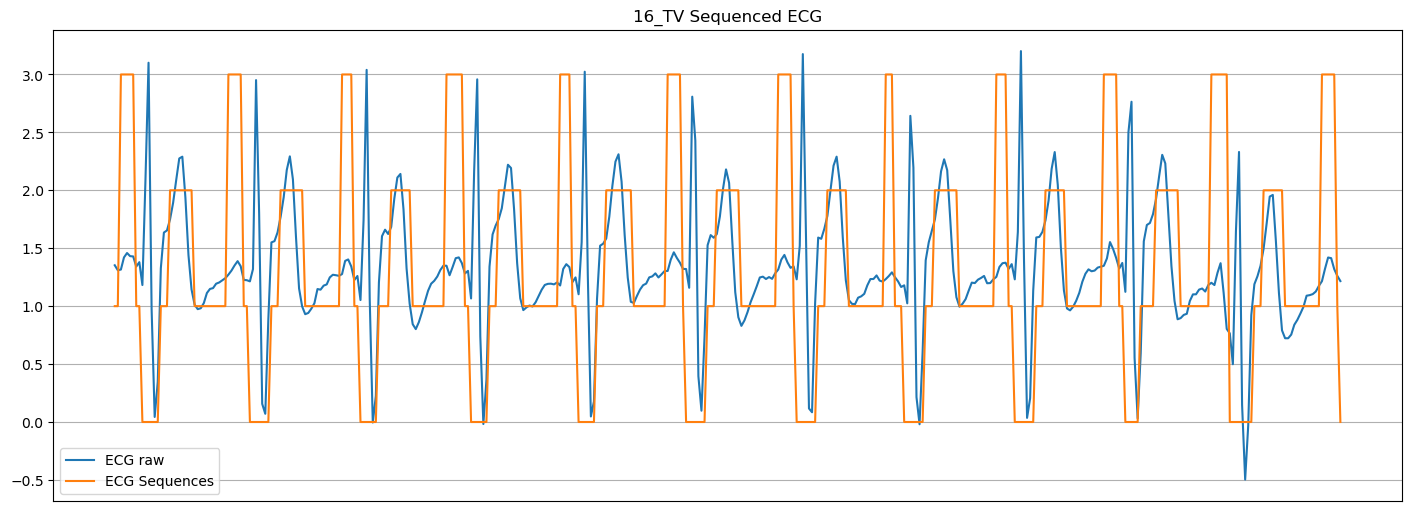

In [13]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Sequenced ECG')
plt.plot((pplib.min_max_norm2(ecg_df.iloc[63][2])*2 +1.5)[300:700], label = 'ECG raw')
plt.plot(ecg_state_predictions[63][300:700], label='ECG Sequences')
plt.xticks([])
plt.legend(loc=3)
plt.grid()
plt.show()

## ECG and PCG Overlapping

### Raw signals overlapping

C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\2079216461.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(pplib.min_max_norm2(ecg_df.iloc[63][2])[300:700], label = 'ECG raw')
C:\Users\Asus\AppData\Local\Temp\ipykernel_7496\2079216461.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot((pplib.min_max_norm2(pcg_df.iloc[63][2]))[300:700], label = 'PCG raw')


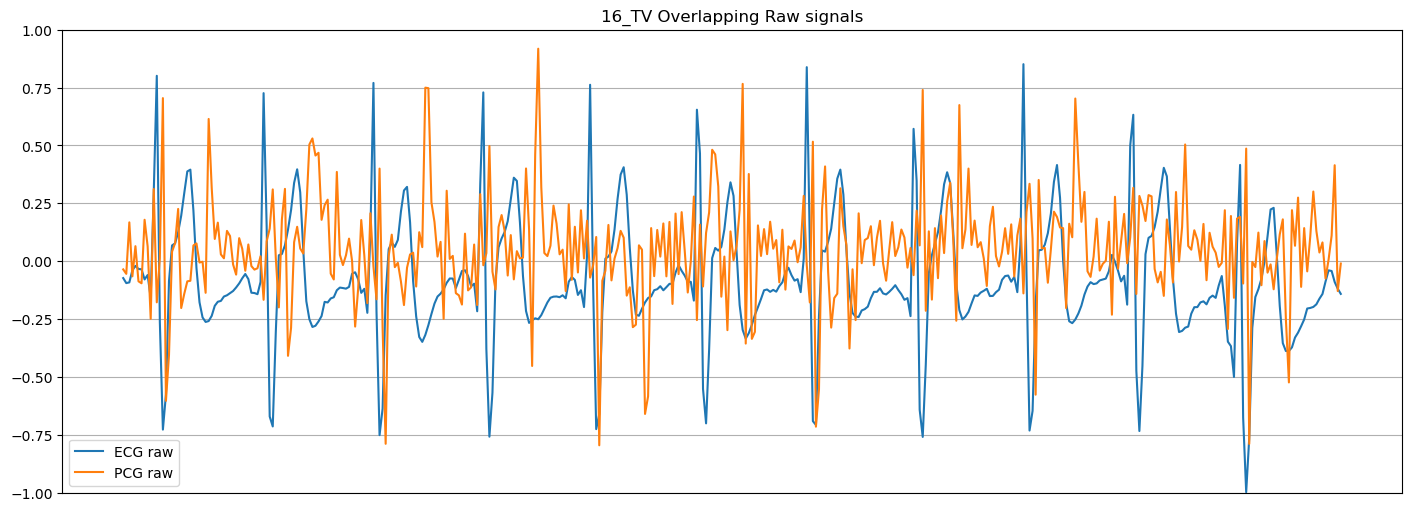

In [14]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Overlapping Raw signals')
plt.plot(pplib.min_max_norm2(ecg_df.iloc[63][2])[300:700], label = 'ECG raw')
plt.plot((pplib.min_max_norm2(pcg_df.iloc[63][2]))[300:700], label = 'PCG raw')
plt.xticks([])
plt.ylim(-1, 1)
plt.legend(loc=3)
plt.grid()
plt.show()

### Probabilities overlapping

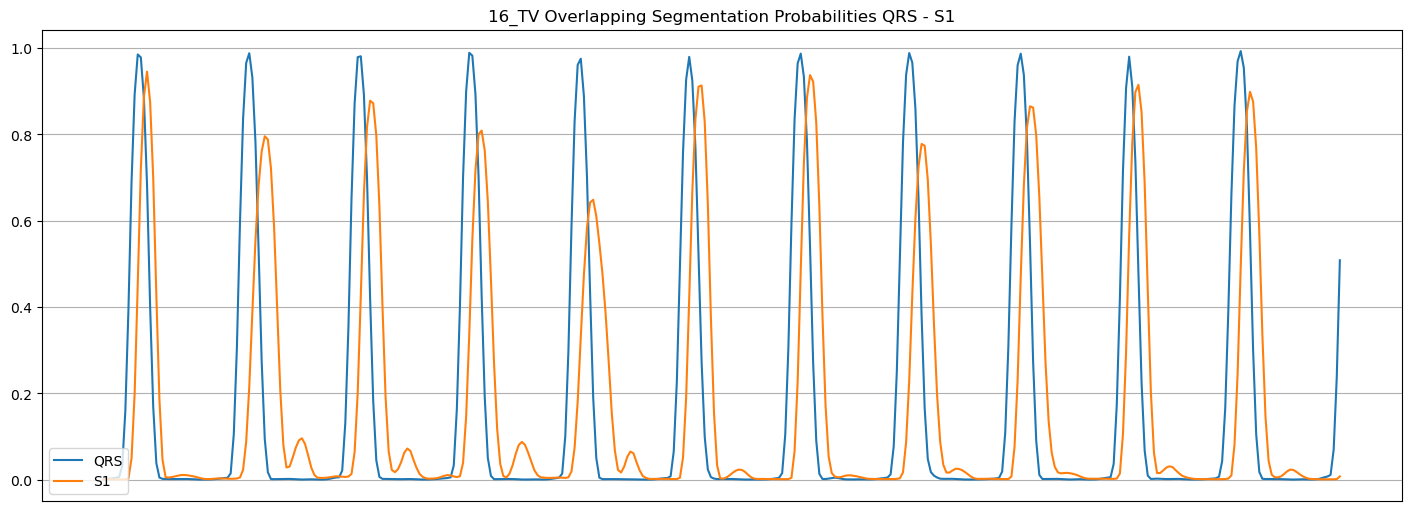

In [15]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Overlapping Segmentation Probabilities QRS - S1')
plt.plot(ecg_processed_predictions[63][300:700, 2], label='QRS')
plt.plot(pcg_processed_predictions[63][300:700, 0], label='S1')
plt.xticks([])
plt.legend(loc=3)
plt.grid()
plt.show()

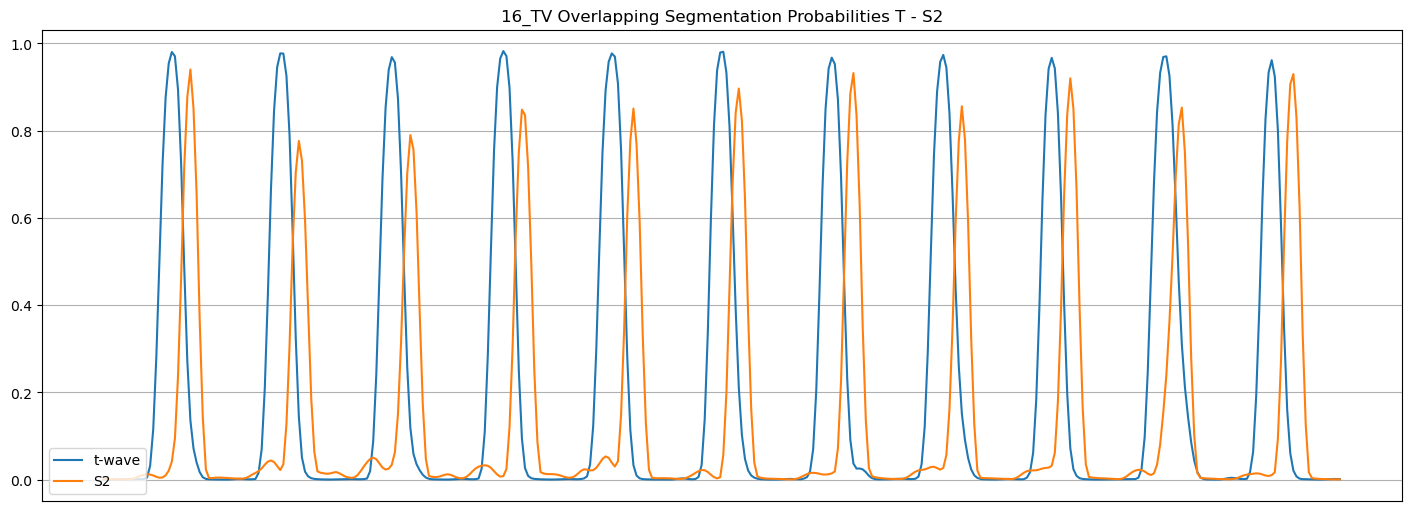

In [16]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Overlapping Segmentation Probabilities T - S2')
plt.plot(ecg_processed_predictions[63][300:700, 3], label='t-wave')
plt.plot(pcg_processed_predictions[63][300:700, 2], label='S2')
plt.xticks([])
plt.legend(loc=3)
plt.grid()
plt.show()

### Sequences Overlapping

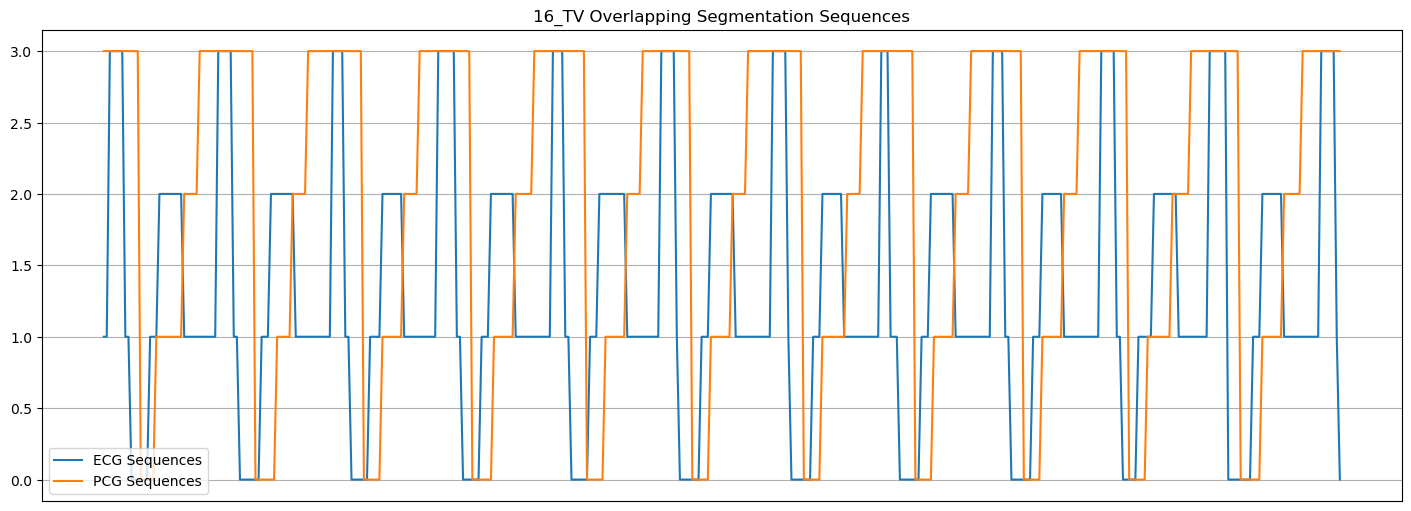

In [17]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Overlapping Segmentation Sequences')
plt.plot(ecg_state_predictions[63][300:700], label='ECG Sequences')
plt.plot(pcg_state_predictions[63][300:700], label='PCG Sequences')
plt.xticks([])
plt.legend(loc=3)
plt.grid()
plt.show()

# Experiment 1: Align delineations and match count (counts presence, not number of points)

### Correlation ECG to PCG and get Peaks indices

In [18]:

e_to_p_correlation = signal.correlate(ecg_state_predictions[63], pcg_state_predictions[63], mode='full')
e_to_p_corr_lags = signal.correlation_lags(ecg_state_predictions[63].size, pcg_state_predictions[63].size, mode='full')
e_to_p_lag = e_to_p_corr_lags[np.argmax(e_to_p_correlation)]
print('ECG to PCG lag: ', e_to_p_lag)

ECG to PCG lag:  -5


Align and trim signals

In [19]:
corrected_ecg = ecg_state_predictions[63][:e_to_p_lag]
corrected_pcg = pcg_state_predictions[63][abs(e_to_p_lag):]

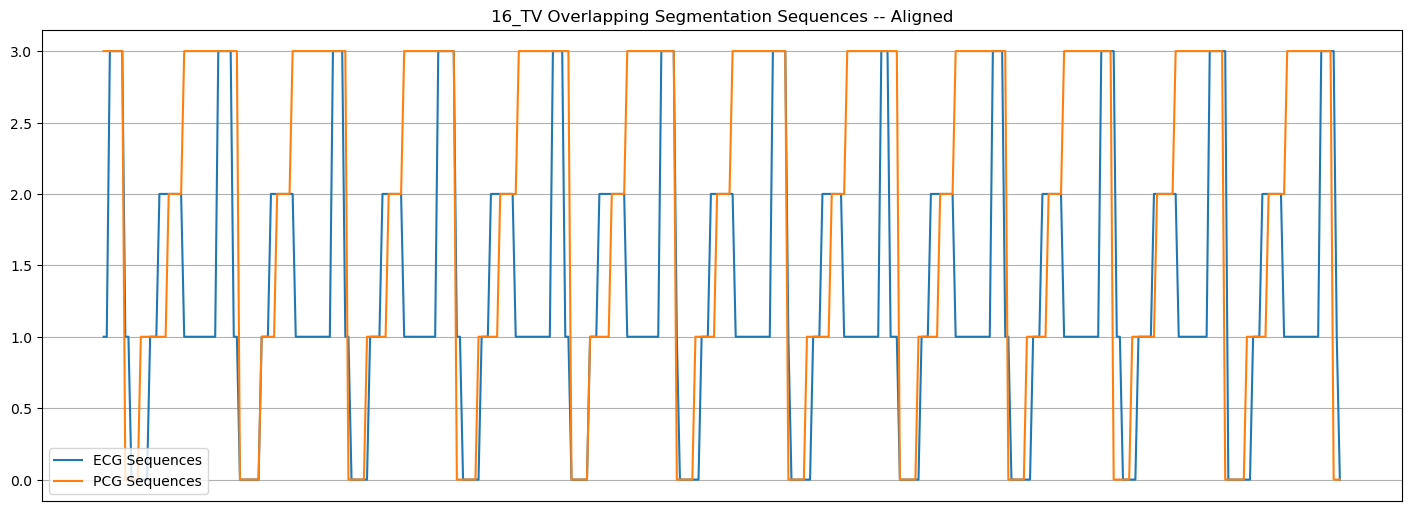

In [20]:
plt.figure(layout='constrained', figsize=(14,5))
plt.title('16_TV Overlapping Segmentation Sequences -- Aligned')
plt.plot(corrected_ecg[300:700], label='ECG Sequences')
plt.plot(corrected_pcg[300:700], label='PCG Sequences')
plt.xticks([])
plt.legend(loc=3)
plt.grid()
plt.show()

In [21]:
correlation = signal.correlate(corrected_ecg, corrected_pcg, mode='full')
corr_lags = signal.correlation_lags(corrected_ecg.size, corrected_pcg.size, mode='full')
lag = corr_lags[np.argmax(correlation)]
print('ECG to PCG lag: ', lag)

ECG to PCG lag:  0


### Cardiac Rhythm calculation based on ECG

In [22]:
r_count = ftelib.count_segments(corrected_ecg,0)
cardiac_rhythm_r = ftelib.calculate_bpm(r_count, len(corrected_ecg))

print("Cardiac Rhythm based on QRS count: ", cardiac_rhythm_r)

Cardiac Rhythm based on QRS count:  84.14872798434442


In [23]:
t_count = ftelib.count_segments(corrected_ecg,2)
cardiac_rhythm_t = ftelib.calculate_bpm(t_count, len(corrected_ecg))

print("Cardiac Rhythm based on t-wave count: ", cardiac_rhythm_t)

Cardiac Rhythm based on t-wave count:  86.10567514677103


### Cardiac Rhythm calculation based on PCG

In [24]:
s1_count = ftelib.count_segments(corrected_pcg,0)
cardiac_rhythm_s1 = ftelib.calculate_bpm(s1_count, len(corrected_pcg))

print("Cardiac Rhythm based on S1 count: ", cardiac_rhythm_s1)

Cardiac Rhythm based on S1 count:  84.14872798434442


In [25]:
s2_count = ftelib.count_segments(corrected_pcg,2)
cardiac_rhythm_s2 = ftelib.calculate_bpm(s2_count, len(corrected_pcg))

print("Cardiac Rhythm based on S2 count: ", cardiac_rhythm_s2)

Cardiac Rhythm based on S2 count:  86.10567514677103


### Simmilarity or disperssion measurement between cardiac rhythm measurements?

**How create an unique ~averaged~ measurement between the 4 metrics, or ECG-only metrics, or PCG-only metrics?**

**How to normalize the lag mesurement with the cardiac rhythm?**

## 1.1 Count up matches (window overlapping counting)

Count the number of window matches between ECG and PCG, normalize it with cardiac cycle? Should I do QRS-S1 t-S2 separately and then average? Or how can I mixture both matches counting?

In [26]:
# Extract intervals from the delineation sequences

def get_intervals(signal, target_label, min_duration=1):
    """
    Extract intervals (start, end indices) where signal == target_label.
    Only intervals with duration >= min_duration are returned.
    """
    intervals = []
    in_interval = False
    start = None
    for i, val in enumerate(signal):
        if val == target_label and not in_interval:
            in_interval = True
            start = i
        elif val != target_label and in_interval:
            end = i  # end is the first index where value changes
            if (end - start) >= min_duration:
                intervals.append((start, end))
            in_interval = False
    # If the signal ends while still in an interval:
    if in_interval and (len(signal) - start) >= min_duration:
        intervals.append((start, len(signal)))
    return intervals

In [27]:
# If the intervals match in at least one point, the overlap time is presented

def compute_overlap(interval_a, interval_b):
    """
    Compute the overlap between two intervals.
    Each interval is a tuple (start, end).
    """
    start_a, end_a = interval_a
    start_b, end_b = interval_b
    overlap = max(0, min(end_a, end_b) - max(start_a, start_b))
    return overlap


In [28]:
def match_intervals(ref_intervals, test_intervals, min_overlap=1):
    """
    For each reference interval, check if there is any test interval with
    at least min_overlap samples overlapping.
    Returns the number of matches.
    """
    matches = 0
    for ref in ref_intervals:
        matched = False
        for test in test_intervals:
            if compute_overlap(ref, test) >= min_overlap:
                matched = True
                break
        if matched:
            matches += 1
    return matches

In [29]:
## Test alignment function before setting the function

In [30]:
def alignment_metric(ecg_signal, pcg_signal, lambda_penalty=0.5, min_duration=1, min_overlap=1):
    """
    Compute the bidirectional alignment metric for the fiducial segments.
    Assumes:
      - ECG: QRS (0) and T-wave (2)
      - PCG: S1 (0) and S2 (2)
    Returns the overall metric and individual directional scores.
    """
    # Extract intervals for physiologically valid segments
    ecg_qrs = get_intervals(ecg_signal, target_label=0, min_duration=min_duration)
    ecg_twave = get_intervals(ecg_signal, target_label=2, min_duration=min_duration)
    pcg_s1 = get_intervals(pcg_signal, target_label=0, min_duration=min_duration)
    pcg_s2 = get_intervals(pcg_signal, target_label=2, min_duration=min_duration)
    
    # ECG-to-PCG matching
    # QRS should match with S1, T-wave should match with S2
    match_qrs = match_intervals(ecg_qrs, pcg_s1, min_overlap=min_overlap)
    match_twave = match_intervals(ecg_twave, pcg_s2, min_overlap=min_overlap)
    total_ecg = len(ecg_qrs) + len(ecg_twave)
    matches_ecg = match_qrs + match_twave
    # Apply linear penalty for missing matches
    score_ecg_to_pcg = (matches_ecg - lambda_penalty * (total_ecg - matches_ecg)) / total_ecg if total_ecg > 0 else 0

    # PCG-to-ECG matching
    match_s1 = match_intervals(pcg_s1, ecg_qrs, min_overlap=min_overlap)
    match_s2 = match_intervals(pcg_s2, ecg_twave, min_overlap=min_overlap)
    total_pcg = len(pcg_s1) + len(pcg_s2)
    matches_pcg = match_s1 + match_s2
    score_pcg_to_ecg = (matches_pcg - lambda_penalty * (total_pcg - matches_pcg)) / total_pcg if total_pcg > 0 else 0

    # Overall metric is the average of both directional scores
    overall_metric = 0.5 * (score_ecg_to_pcg + score_pcg_to_ecg)
    return overall_metric, score_ecg_to_pcg, score_pcg_to_ecg


In [31]:
overall_metric, score_ecg_to_pcg, score_pcg_to_ecg = alignment_metric(corrected_ecg, corrected_ecg)
print("Overall Alignment Metric:", overall_metric)
print("ECG-to-PCG Score:", score_ecg_to_pcg)
print("PCG-to-ECG Score:", score_pcg_to_ecg)

Overall Alignment Metric: 1.0
ECG-to-PCG Score: 1.0
PCG-to-ECG Score: 1.0
